In [66]:
import pandas as pd
import glob
import os
import csv
from datetime import datetime, timedelta
import json
from IPython.display import display, HTML
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Big file

In [140]:
df = pd.read_csv('grouped_unrounded.csv', dtype={'datetime': "string", "power": float}, low_memory=False)
df['datetime'] = pd.to_datetime(df['datetime'])

In [141]:
df.set_index('datetime', inplace=True)
df

power
datetime                       
2022-02-14 15:05:56.374  115.90
2022-02-14 15:05:56.865  116.25
2022-02-14 15:05:57.344  116.10
2022-02-14 15:05:57.826  115.80
2022-02-14 15:05:58.305  115.25
...                         ...
2022-06-13 09:19:20.444   79.80
2022-06-13 09:19:20.936   81.25
2022-06-13 09:19:21.415   80.80
2022-06-13 09:19:21.897   82.80
2022-06-13 09:19:22.376   81.06

[11232088 rows x 1 columns]

### Fixing power difference

In [142]:
power_diff = 9.162812939836797
start_increase = "2022-05-23 09:48:48"
end_increase = "2022-05-24 14:00:00"

increased_section = df[start_increase : end_increase]
increased_section = increased_section.apply(lambda x: x - power_diff)

df.update(increased_section)

<AxesSubplot:xlabel='datetime'>

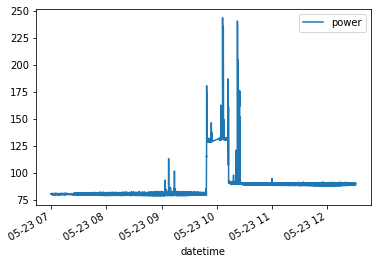

In [122]:
#Before
df['23-05-2022 07:00':'23-05-2022 12:30'].plot()

<AxesSubplot:xlabel='datetime'>

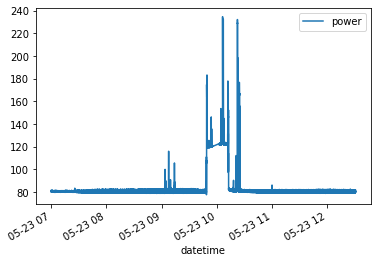

In [143]:
#After
df['23-05-2022 07:00':'23-05-2022 12:30'].plot()

In [144]:
df.to_csv("grouped_unrounded_adjusted.csv")

In [19]:
with open("power/db_vmaf_yuv_2022-06-09.json") as f:
            vmaf_data = json.load(f)
        
with open("power/db_vmaf_yuv_2160-2022-06-29.json") as f:
            vmaf_data_2160 = json.load(f)
        
for key in vmaf_data.keys():
    start_index = int(list(vmaf_data[key].keys())[-1])
    for val in vmaf_data_2160[key].values():
        vmaf_data[key][start_index] = val
        start_index += 1

In [21]:
with open("power/db_vmaf_yuv_combined.json", "w") as f:
    json.dump(vmaf_data, f)

## Average power consumption

In [57]:
class VideoData:
    def __init__(self, log_csv_name, vmaf_csv_name, vmaf = False):
        df = pd.read_csv(log_csv_name, dtype={'datetime': "string", "power": float}, low_memory=False)
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)
        
        with open(vmaf_csv_name) as f:
            vmaf_data = json.load(f)
        
        self.log_df = df
        self.vmaf_data = vmaf_data
        #Change if you want to include VVC (skews graph)
        self.violin_include_VVC = False
        self.vmaf = vmaf
        
    def calc_energies(self):
        self.get_videos_flat()
        avg_energy = [self.get_energy_video(time) for time in self.get_video_times()]
        
        evaluated_qp_energy = [sum(energy[:-1])[0] for energy in avg_energy]
        target_encode_energy = [energy[-1][0] for energy in avg_energy]
        
        video_names = [video['video_name'] for video in self.videos_flat.values()]
        res = [video['resolution'] for video in self.videos_flat.values()]
        codec = [video['codec'] for video in self.videos_flat.values()]
        genre = [name.split("_")[0] for name in video_names]
        bitrate = [video['target_encode']['bitrate'] for video in self.videos_flat.values()]
        encoding_energy = [qp + target for qp, target in zip(evaluated_qp_energy, target_encode_energy)]
        vmaf_bitrate = [video["vmaf_target"]["bitrate"] if "vmaf_target" in video else video['target_encode']['bitrate'] for video in self.videos_flat.values()]
        vmaf = [video["vmaf_target"]["vmaf"] if "vmaf_target" in video else video['target_encode']['vmaf'] for video in self.videos_flat.values()]

        d = {"codec": codec, "video_name": video_names, "genre": genre, "resolution": res, "target bitrate": bitrate, "vmaf bitrate": vmaf_bitrate, "vmaf": vmaf, "evaluated qp energy (J)": evaluated_qp_energy, "target encode energy (J)": target_encode_energy, "encoding energy (J)": encoding_energy}

        powers_df = pd.DataFrame(data = d)
        
        self.powers_df = powers_df
        
    def get_energy_video(self, time):
        #average power in watts
        avg_power = [self.log_df[time[0] : time[1]].mean() for time in time]
        #energy in joules
        energy = [power * (datetime.strptime(time[1], "%Y-%m-%d %H:%M:%S.%f") - datetime.strptime(time[0], "%Y-%m-%d %H:%M:%S.%f")).total_seconds() for power, time in zip(avg_power, time)] #??

        return energy

    def get_video_time(self, video):
        return [[qp["start_time"], qp["end_time"]] for qp in video["evaluated_qps"]] + [[video["target_encode"]["start_time"], video["target_encode"]["end_time"]]]

    def get_video_time_vmaf(self, video):
        return [[qp["start_time_vmaf"], qp["end_time_vmaf"]] for qp in video["evaluated_qps"]] + [[video["target_encode"]["start_time_vmaf"], video["target_encode"]["end_time_vmaf"]]]
        
    def get_video_times(self):
        if self.vmaf:
            video_times = [self.get_video_time_vmaf(video) for video in self.videos_flat.values()]
        else:
            video_times = [self.get_video_time(video) for video in self.videos_flat.values()]
        
        return video_times
    
    def get_videos_flat(self):
        vids_flat = {}

        for codec in self.vmaf_data.keys():

            for i, vid in enumerate(self.vmaf_data[codec].values()):
                if "error" in vid:
                    continue
                vid["codec"] = codec
                vids_flat[f"{i}-{codec}"] = vid
                
        self.videos_flat = vids_flat

    def fill_complete_csv(self):
        if not self.videos_flat:
            self.get_videos_flat()

        for vid in self.videos_flat.values():
            video_times = self.get_video_time(vid)
            video_times_vmaf = self.get_video_time_vmaf(vid)

            energies = self.get_energy_video(video_times)
            energies_vmaf = self.get_energy_video(video_times_vmaf)
            
            evaluated_qp_energy = sum(energies[:-1])[0]
            target_encode_energy = energies[-1][0]

            evaluated_qp_energy_vmaf = sum(energies_vmaf[:-1])[0]
            target_encode_energy_vmaf = energies_vmaf[-1][0]
            
            for i, qp in enumerate(vid["evaluated_qps"]):
                qp["energy"] = energies[i][0]
                qp["energy_vmaf"] = energies_vmaf[i][0]
                
            vid["target_encode"]["energy"] = target_encode_energy
            vid["target_encode"]["energy_vmaf"] = target_encode_energy_vmaf
            
            vid["evaluated_qp_energy"] = evaluated_qp_energy
            vid["evaluated_qp_energy"] = evaluated_qp_energy_vmaf

    def get_violin_graphs(self):
        df = self.powers_df
        if not self.violin_include_VVC:
            df = self.powers_df[self.powers_df.codec != "VVC"]

        sns.catplot(x="resolution", y="encoding energy (J)", col="genre", hue="codec",
                    data=df, palette="Set2", scale="count", inner="quartile",
                    scale_hue=False, bw=.2, kind="violin",col_wrap=5,linewidth=.5)
        
        if self.vmaf:
            plt.savefig("res_vs_encoding_energy_violin_vmaf_VVC.pdf" if self.violin_include_VVC else "res_vs_encoding_energy_violin_vmaf.pdf")
        else:
            plt.savefig("res_vs_encoding_energy_violin__VVC.pdf" if self.violin_include_VVC else "res_vs_encoding_energy_violin.pdf")

    def get_res_energy_graph(self):
        df = self.powers_df
        if not self.violin_include_VVC:
            df = self.powers_df[self.powers_df.codec != "VVC"]

        sns.boxplot(x="resolution", y="encoding energy (J)", hue="codec",
                 data=df, palette="Set3", showfliers = False)
        if self.vmaf:
            plt.savefig("res_vs_encoding_energy_box_vmaf_VVC.pdf" if self.violin_include_VVC else "res_vs_encoding_energy_box_vmaf.pdf")
        else:
            plt.savefig("res_vs_encoding_energy_box_VVC.pdf" if self.violin_include_VVC else "res_vs_encoding_energy_box.pdf")
    def get_res_bitrate_graph(self):
        df = self.powers_df
        if not self.violin_include_VVC:
            df = self.powers_df[self.powers_df.codec != "VVC"]
            
        if self.vmaf:
            sns.boxplot(x="resolution", y="vmaf bitrate", hue="codec", 
                        data=df, palette="Set3", showfliers = False)
            plt.savefig("bitrate_vs_encoding_energy_box_vmaf_VVC.pdf" if self.violin_include_VVC else "bitrate_vs_encoding_energy_box_vmaf.pdf")
        else:
            sns.boxplot(x="resolution", y="target bitrate", hue="codec", 
                        data=df, palette="Set3", showfliers = False)
            plt.savefig("bitrate_vs_encoding_energy_box_VVC.pdf" if self.violin_include_VVC else "bitrate_vs_encoding_energy_box.pdf")
    


In [58]:
VideoDataInstance = VideoData("grouped_unrounded_adjusted.csv", "power/db_vmaf_yuv_2022-06-09.json", vmaf=False)

In [59]:
VideoDataInstance.calc_energies()

In [56]:
VideoDataInstance.powers_df

codec                 video_name           genre  resolution  \
0     libvpx-vp9       Animation_1080P-05f8       Animation         360   
1     libvpx-vp9       Animation_1080P-05f8       Animation         720   
2     libvpx-vp9       Animation_1080P-05f8       Animation        1080   
3     libvpx-vp9       CoverSong_1080P-0188       CoverSong         360   
4     libvpx-vp9           HowTo_1080P-0267           HowTo         360   
...          ...                        ...             ...         ...   
1908         VVC      LyricVideo_1080P-63d9      LyricVideo        1080   
1909         VVC        NewsClip_1080P-4241        NewsClip        1080   
1910         VVC  TelevisionClip_1080P-5278  TelevisionClip        1080   
1911         VVC       Animation_1080P-4be3       Animation        1080   
1912         VVC       CoverSong_1080P-3409       CoverSong        1080   

      target bitrate  vmaf bitrate       vmaf  evaluated qp energy (J)  \
0           284.8130      284.8130  79.578062             13925.956660   
1           994.4860      994.4860  91.806144             23546.986091   
2          1759.7110     1759.7110  94.331030             64129.589067   
3           271.0210      271.0210  34.804728             28572.139645   
4           265.2110      265.2110  87.099016              6421.879718   
...              ...           ...        ...                      ...   
1908       1818.8465     1530.9912  94.306977            390560.030743   
1909       1735.2056     1019.2140  93.793841            566266.483218   
1910       1628.9615      963.1600  89.686845            524742.145847   
1911       1997.7283     1166.1739  89.356218            971056.131527   
1912       1748.0788     1112.0172  88.745158            258032.343585   

      target encode energy (J)  encoding energy (J)  
0                  2126.845432         1.605280e+04  
1                  5065.060267         2.861205e+04  
2                 10819.900074         7.494949e+04  
3                  3711.859922         3.228400e+04  
4                  1502.937469         7.924817e+03  
...                        ...                  ...  
1908              96583.950777         4.871440e+05  
1909             122857.714010         6.891242e+05  
1910             101046.623594         6.257888e+05  
1911             159009.673517         1.130066e+06  
1912              58503.262384         3.165356e+05  

[1913 rows x 10 columns]

In [6]:
VideoDataInstance.fill_complete_csv()

In [166]:
VideoDataInstance.videos_flat

{'0-libvpx-vp9': {'video_name': 'Animation_1080P-05f8',
  'resolution': 360,
  'evaluated_qps': [{'output_video_file_path': '/home/csxds/video_temp/videos/Animation_05f8_640x360_libvpx-vp9_27.mp4',
    'bitrate': 1650.553,
    'start_time': '2022-05-02 15:40:31.537',
    'end_time': '2022-05-02 15:41:04.308',
    'qp': 27,
    'vmaf': 92.546579,
    'start_time_vmaf': '2022-05-02 15:41:05.883',
    'end_time_vmaf': '2022-05-02 15:41:48.925',
    'vvcdec_output_path': None,
    'resized': True},
   {'output_video_file_path': '/home/csxds/video_temp/videos/Animation_05f8_640x360_libvpx-vp9_33.mp4',
    'bitrate': 1058.271,
    'start_time': '2022-05-02 15:41:49.071',
    'end_time': '2022-05-02 15:42:17.777',
    'qp': 33,
    'vmaf': 90.232278,
    'start_time_vmaf': '2022-05-02 15:42:19.354',
    'end_time_vmaf': '2022-05-02 15:43:02.277',
    'vvcdec_output_path': None,
    'resized': True},
   {'output_video_file_path': '/home/csxds/video_temp/videos/Animation_05f8_640x360_libvpx-vp9

In [24]:
power_df = VideoDataInstance.powers_df
display(power_df.groupby(["codec"]).size())
display(power_df[power_df.resolution == 360].groupby(["codec"]).size())
display(power_df[power_df.resolution == 720].groupby(["codec"]).size())
display(power_df[power_df.resolution == 1080].groupby(["codec"]).size())

codec
VVC            75
libsvtav1     449
libvpx-vp9    468
libx264       461
libx265       460
dtype: int64

codec
libsvtav1     147
libvpx-vp9    157
libx264       154
libx265       154
dtype: int64

codec
libsvtav1     155
libvpx-vp9    160
libx264       157
libx265       157
dtype: int64

codec
VVC            75
libsvtav1     147
libvpx-vp9    151
libx264       150
libx265       149
dtype: int64

In [6]:
VideoDataInstance.powers_df.groupby(["genre"]).size()

genre
Animation         213
CoverSong         244
HowTo             192
Lecture           272
LiveMusic         199
LyricVideo        149
MusicVideo        245
NewsClip          199
TelevisionClip    200
dtype: int64

In [8]:
test_df = VideoDataInstance.powers_df[VideoDataInstance.powers_df.codec != "VVC"]
test_df = test_df[test_df.genre == "TelevisionClip"]
test_df = test_df.query('codec == "libx265" or codec == "libvpx-vp9"')
# test_df = test_df[test_df.codec == "libx265" or test_df.codec == "libvpx-vp9"]
test_df = test_df[test_df.resolution == 1080]
# test_df.to_excel("power_df.xlsx")
test_df

codec                 video_name           genre  resolution  \
21    libvpx-vp9  TelevisionClip_1080P-0604  TelevisionClip        1080   
48    libvpx-vp9  TelevisionClip_1080P-3758  TelevisionClip        1080   
75    libvpx-vp9  TelevisionClip_1080P-39e3  TelevisionClip        1080   
99    libvpx-vp9  TelevisionClip_1080P-3b9b  TelevisionClip        1080   
126   libvpx-vp9  TelevisionClip_1080P-3d10  TelevisionClip        1080   
147   libvpx-vp9  TelevisionClip_1080P-3d83  TelevisionClip        1080   
173   libvpx-vp9  TelevisionClip_1080P-3e42  TelevisionClip        1080   
193   libvpx-vp9  TelevisionClip_1080P-401e  TelevisionClip        1080   
220   libvpx-vp9  TelevisionClip_1080P-4c24  TelevisionClip        1080   
243   libvpx-vp9  TelevisionClip_1080P-525d  TelevisionClip        1080   
269   libvpx-vp9  TelevisionClip_1080P-5278  TelevisionClip        1080   
296   libvpx-vp9  TelevisionClip_1080P-5e68  TelevisionClip        1080   
322   libvpx-vp9  TelevisionClip_1080P-6026  TelevisionClip        1080   
346   libvpx-vp9  TelevisionClip_1080P-6282  TelevisionClip        1080   
368   libvpx-vp9  TelevisionClip_1080P-63e6  TelevisionClip        1080   
392   libvpx-vp9  TelevisionClip_1080P-68c6  TelevisionClip        1080   
950      libx265  TelevisionClip_1080P-0604  TelevisionClip        1080   
977      libx265  TelevisionClip_1080P-3758  TelevisionClip        1080   
1004     libx265  TelevisionClip_1080P-39e3  TelevisionClip        1080   
1027     libx265  TelevisionClip_1080P-3b9b  TelevisionClip        1080   
1052     libx265  TelevisionClip_1080P-3d10  TelevisionClip        1080   
1073     libx265  TelevisionClip_1080P-3d83  TelevisionClip        1080   
1099     libx265  TelevisionClip_1080P-3e42  TelevisionClip        1080   
1119     libx265  TelevisionClip_1080P-401e  TelevisionClip        1080   
1146     libx265  TelevisionClip_1080P-4c24  TelevisionClip        1080   
1169     libx265  TelevisionClip_1080P-525d  TelevisionClip        1080   
1195     libx265  TelevisionClip_1080P-5278  TelevisionClip        1080   
1222     libx265  TelevisionClip_1080P-5e68  TelevisionClip        1080   
1244     libx265  TelevisionClip_1080P-6026  TelevisionClip        1080   
1268     libx265  TelevisionClip_1080P-6282  TelevisionClip        1080   
1290     libx265  TelevisionClip_1080P-63e6  TelevisionClip        1080   
1314     libx265  TelevisionClip_1080P-68c6  TelevisionClip        1080   

      target bitrate  vmaf bitrate       vmaf  evaluated qp energy (J)  \
21          1904.564      1904.564  82.956053            126262.755545   
48          1819.412      1819.412  92.553672             50240.797700   
75          1821.185      1821.185  88.531279             82170.511290   
99          1839.310      1839.310  95.072719             28138.040226   
126         1838.988      1838.988  96.264618             28721.944825   
147         1810.945      1810.945  95.486404             23887.867656   
173         1794.406      1794.406  95.640849             30953.623275   
193         1732.337      1732.337  96.451138             35075.618078   
220         1883.933      1883.933  83.817867             92099.709041   
243         1766.711      1766.711  86.038389             88646.749141   
269         1777.102      1777.102  89.553280             57806.271290   
296         1847.491      1847.491  91.243714             67202.828922   
322         1781.785      1781.785  96.483720             30393.832005   
346         1881.724      1881.724  95.135782             41137.981731   
368         1720.052      1720.052  91.387890             47381.663687   
392         1829.979      1829.979  74.963676            117108.302073   
950         1756.887      1756.887  83.237085             19111.756867   
977         1768.361      1503.322  92.162132             13864.076047   
1004        1787.117      1787.117  86.033270             14844.331097   
1027        1710.940      1710.940  94.862589          

<AxesSubplot:xlabel='vmaf bitrate', ylabel='vmaf'>

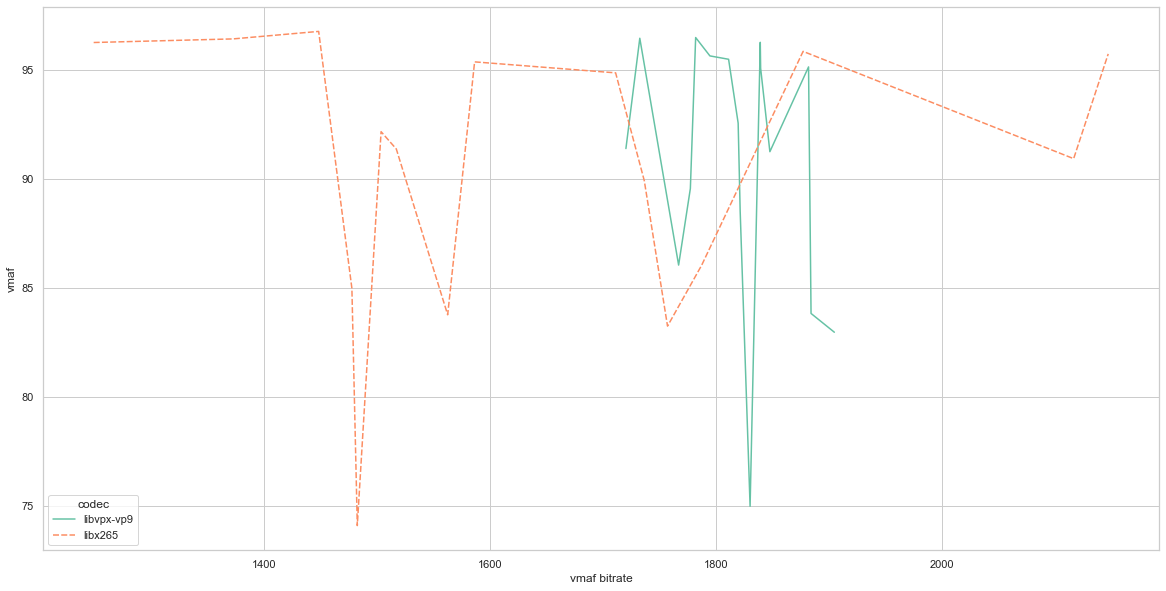

In [9]:
plt.figure(figsize=(20, 10))
sns.lineplot(x="vmaf bitrate", y="vmaf", hue="codec", style="codec", data=test_df, palette="Set2", ci=None, sort=True)

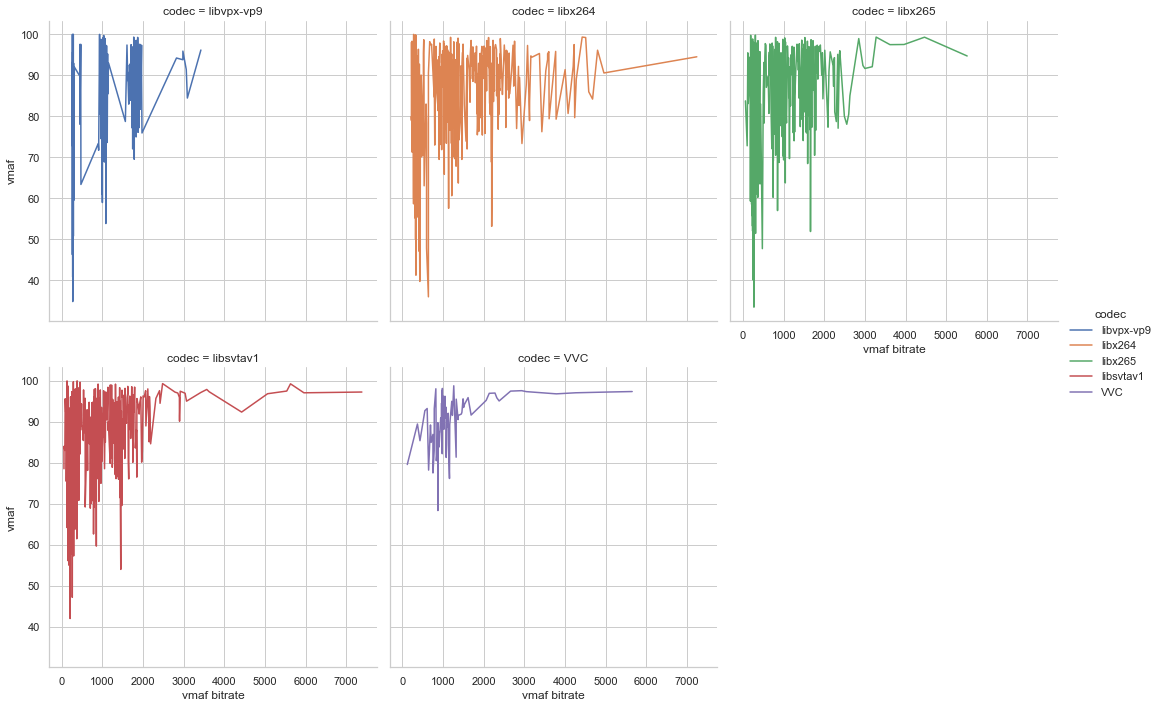

In [214]:
sns.relplot(data=VideoDataInstance.powers_df, x="vmaf bitrate", y="vmaf", hue="codec", col="codec", col_wrap=3, kind="line", legend="full")

Text(0.5, 1.0, 'Combined')

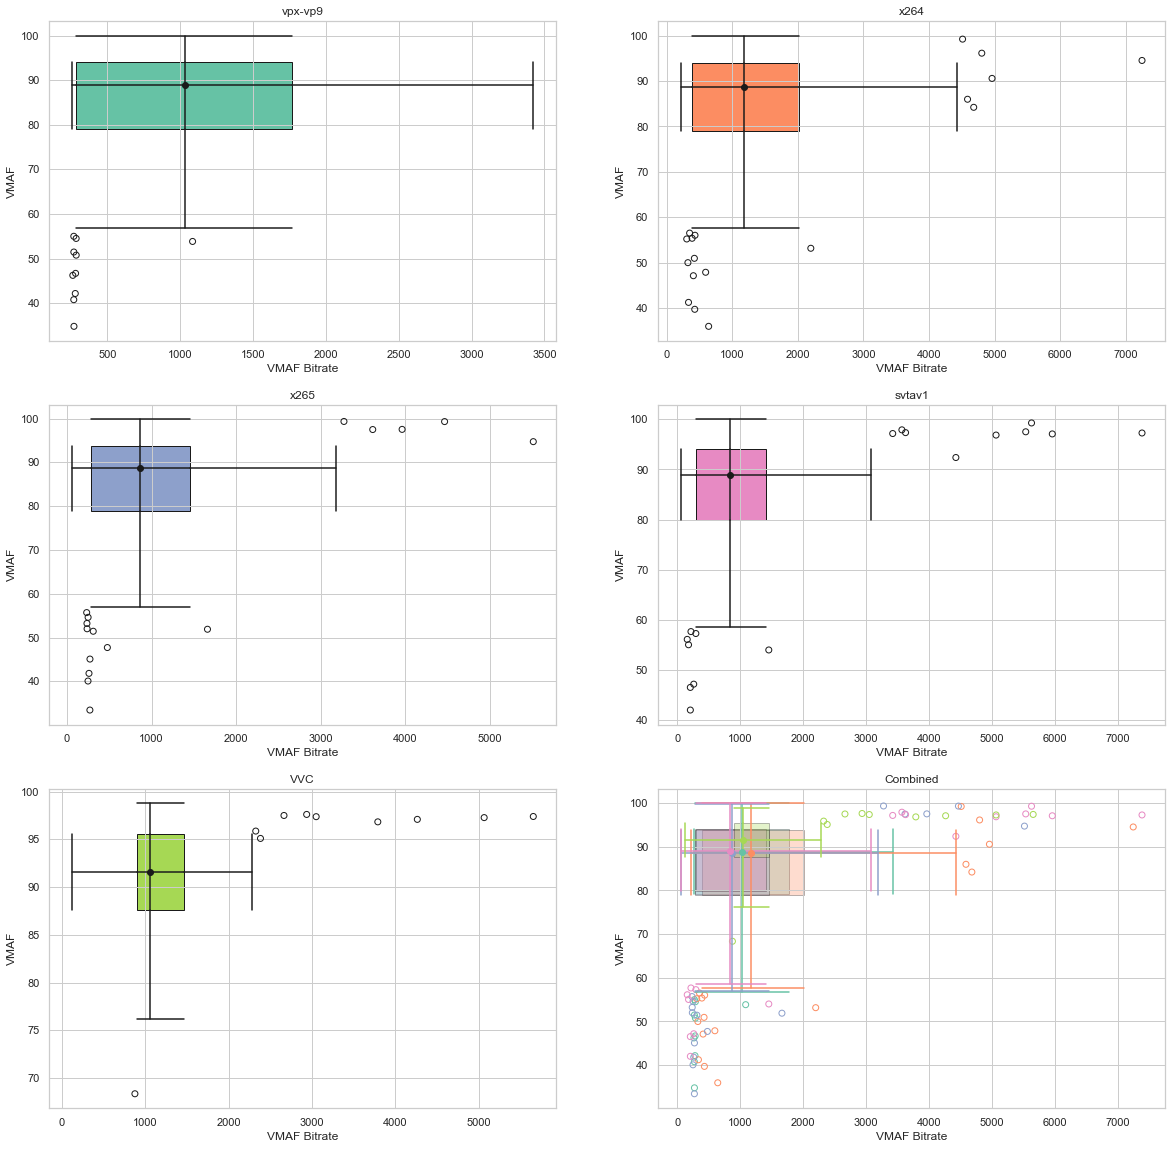

In [121]:
#https://stackoverflow.com/questions/53849636/draw-a-double-box-plot-chart-2-axes-box-plot-box-plot-correlation-diagram-in
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

def boxplot_2d(x,y, ax, whis=1.5, c=sns.color_palette("Set2")[0], color_lines=False):
    xlimits = [np.percentile(x, q) for q in (25, 50, 75)]
    ylimits = [np.percentile(y, q) for q in (25, 50, 75)]

    ##the box
    box = Rectangle(
        (xlimits[0],ylimits[0]),
        (xlimits[2]-xlimits[0]),
        (ylimits[2]-ylimits[0]),
        color=c,
        ec = 'k',
        zorder=0,
        alpha=0.3 if color_lines else 1
    )
    ax.add_patch(box)

    ##the x median
    vline = Line2D(
        [xlimits[1],xlimits[1]],[ylimits[0],ylimits[2]],
        color= c if color_lines else 'k',
        zorder=1
    )
    ax.add_line(vline)

    ##the y median
    hline = Line2D(
        [xlimits[0],xlimits[2]],[ylimits[1],ylimits[1]],
        color=c if color_lines else 'k',
        zorder=1
    )
    ax.add_line(hline)

    ##the central point
    ax.plot([xlimits[1]],[ylimits[1]], color=c if color_lines else 'k', marker='o')

    ##the x-whisker
    ##defined as in matplotlib boxplot:
    ##As a float, determines the reach of the whiskers to the beyond the
    ##first and third quartiles. In other words, where IQR is the
    ##interquartile range (Q3-Q1), the upper whisker will extend to
    ##last datum less than Q3 + whis*IQR). Similarly, the lower whisker
    ####will extend to the first datum greater than Q1 - whis*IQR. Beyond
    ##the whiskers, data are considered outliers and are plotted as
    ##individual points. Set this to an unreasonably high value to force
    ##the whiskers to show the min and max values. Alternatively, set this
    ##to an ascending sequence of percentile (e.g., [5, 95]) to set the
    ##whiskers at specific percentiles of the data. Finally, whis can
    ##be the string 'range' to force the whiskers to the min and max of
    ##the data.
    iqr = xlimits[2]-xlimits[0]

    ##left
    left = np.min(x[x > xlimits[0]-whis*iqr])
    whisker_line = Line2D(
        [left, xlimits[0]], [ylimits[1],ylimits[1]],
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_line)
    whisker_bar = Line2D(
        [left, left], [ylimits[0],ylimits[2]],
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_bar)

    ##right
    right = np.max(x[x < xlimits[2]+whis*iqr])
    whisker_line = Line2D(
        [right, xlimits[2]], [ylimits[1],ylimits[1]],
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_line)
    whisker_bar = Line2D(
        [right, right], [ylimits[0],ylimits[2]],
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_bar)

    ##the y-whisker
    iqr = ylimits[2]-ylimits[0]

    ##bottom
    bottom = np.min(y[y > ylimits[0]-whis*iqr])
    whisker_line = Line2D(
        [xlimits[1],xlimits[1]], [bottom, ylimits[0]], 
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_line)
    whisker_bar = Line2D(
        [xlimits[0],xlimits[2]], [bottom, bottom], 
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_bar)

    ##top
    top = np.max(y[y < ylimits[2]+whis*iqr])
    whisker_line = Line2D(
        [xlimits[1],xlimits[1]], [top, ylimits[2]], 
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_line)
    whisker_bar = Line2D(
        [xlimits[0],xlimits[2]], [top, top], 
        color = c if color_lines else 'k',
        zorder = 1
    )
    ax.add_line(whisker_bar)

    ##outliers
    mask = (x<left)|(x>right)|(y<bottom)|(y>top)
    ax.scatter(
        x[mask],y[mask],
        facecolors='none', edgecolors=c if color_lines else 'k'
    )

#the figure and axes
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(figsize=(20,20),nrows=3 ,ncols=2)

boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libvpx-vp9"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libvpx-vp9"]["vmaf"], ax=ax1)
ax1.set_xlabel("VMAF Bitrate")
ax1.set_ylabel("VMAF")
ax1.set_title("vpx-vp9")

boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx264"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx264"]["vmaf"], ax=ax2, c=sns.color_palette("Set2")[1])
ax2.set_xlabel("VMAF Bitrate")
ax2.set_ylabel("VMAF")
ax2.set_title("x264")

boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx265"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx265"]["vmaf"], ax=ax3, c=sns.color_palette("Set2")[2])
ax3.set_xlabel("VMAF Bitrate")
ax3.set_ylabel("VMAF")
ax3.set_title("x265")

boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libsvtav1"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libsvtav1"]["vmaf"], ax=ax4, c=sns.color_palette("Set2")[3])
ax4.set_xlabel("VMAF Bitrate")
ax4.set_ylabel("VMAF")
ax4.set_title("svtav1")

boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "VVC"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "VVC"]["vmaf"], ax=ax5, c=sns.color_palette("Set2")[4])
ax5.set_xlabel("VMAF Bitrate")
ax5.set_ylabel("VMAF")
ax5.set_title("VVC")

# boxplot_2d(VideoDataInstance.powers_df["vmaf bitrate"], VideoDataInstance.powers_df["vmaf"], ax=ax6, c=sns.color_palette("Set2")[5])
boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libvpx-vp9"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libvpx-vp9"]["vmaf"], ax=ax6, color_lines=True)
boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx264"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx264"]["vmaf"], ax=ax6, c=sns.color_palette("Set2")[1], color_lines=True)
boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx265"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx265"]["vmaf"], ax=ax6, c=sns.color_palette("Set2")[2], color_lines=True)
boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libsvtav1"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libsvtav1"]["vmaf"], ax=ax6, c=sns.color_palette("Set2")[3], color_lines=True)
boxplot_2d(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "VVC"]["vmaf bitrate"], VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "VVC"]["vmaf"], ax=ax6, c=sns.color_palette("Set2")[4], color_lines=True)
ax6.set_xlabel("VMAF Bitrate")
ax6.set_ylabel("VMAF")
ax6.set_title("Combined")

# plt.savefig("2d_boxplots_combined_res.pdf")

In [156]:
0.9 + (1/100)

0.91

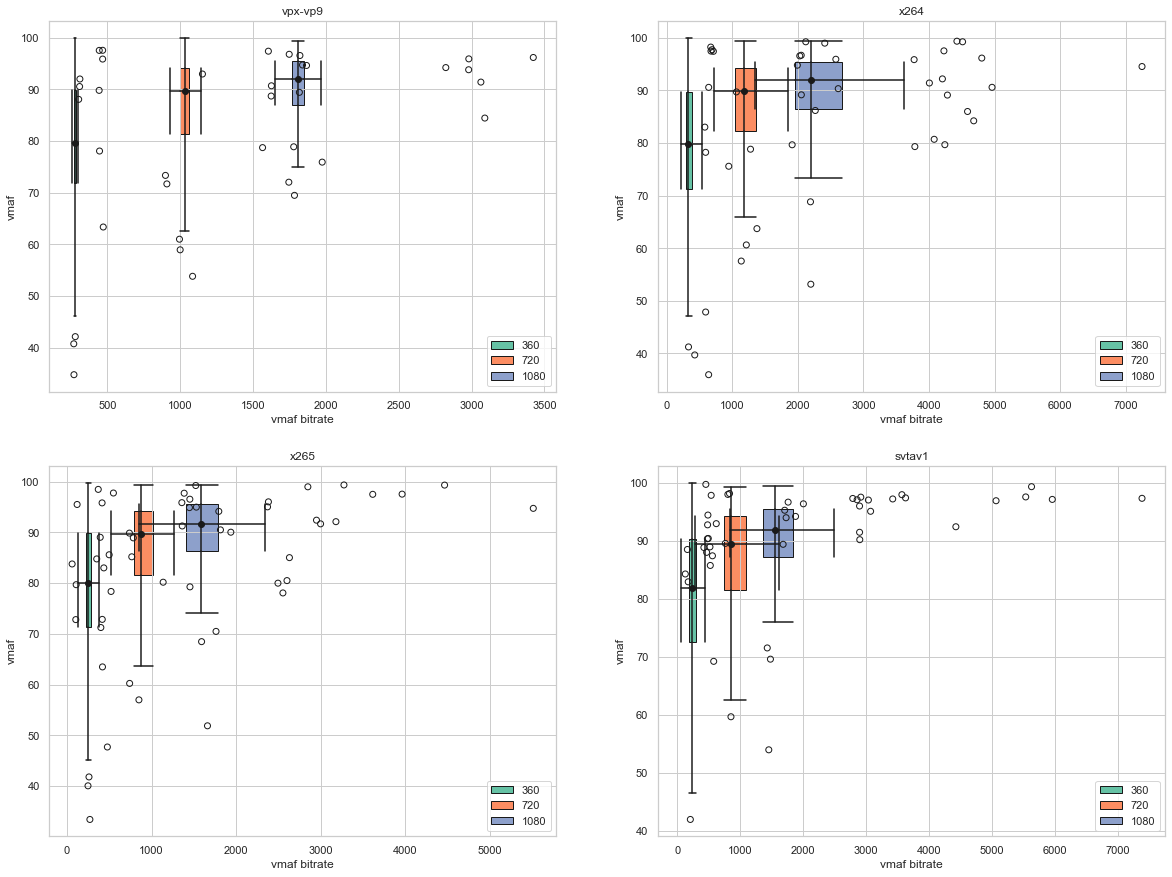

In [165]:
#https://stackoverflow.com/questions/53849636/draw-a-double-box-plot-chart-2-axes-box-plot-box-plot-correlation-diagram-in
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

def boxplot_2d_multiple(data, x_label, y_label, ax, whis=1.5, c=sns.color_palette("Set2")[0], color_lines=False):
    
    boxes = []
    
    for i, res in enumerate([360, 720, 1080]):
        c = sns.color_palette("Set2")[i]
        x = data[data["resolution"] == res][x_label]
        y = data[data["resolution"] == res][y_label]
    
        xlimits = [np.percentile(x, q) for q in (25, 50, 75)]
        ylimits = [np.percentile(y, q) for q in (25, 50, 75)]

        ##the box
        box = Rectangle(
            (xlimits[0],ylimits[0]),
            (xlimits[2]-xlimits[0]),
            (ylimits[2]-ylimits[0]),
            color=c,
            ec = 'k',
            zorder=0,
            alpha=0.3 if color_lines else 1
        )
        boxes.append(box)
        ax.add_patch(box)
#         ax.add_patch(box)

        ##the x median
        ax.add_line(Line2D(
            [xlimits[1],xlimits[1]],[ylimits[0],ylimits[2]],
            color= c if color_lines else 'k',
            zorder=1
        ))
#         ax.add_line(vline)

        ##the y median
        ax.add_line(Line2D(
            [xlimits[0],xlimits[2]],[ylimits[1],ylimits[1]],
            color=c if color_lines else 'k',
            zorder=1
        ))
#         ax.add_line(hline)

        ##the central point
        ax.plot([xlimits[1]],[ylimits[1]], color=c if color_lines else 'k', marker='o')

        ##the x-whisker
        ##defined as in matplotlib boxplot:
        ##As a float, determines the reach of the whiskers to the beyond the
        ##first and third quartiles. In other words, where IQR is the
        ##interquartile range (Q3-Q1), the upper whisker will extend to
        ##last datum less than Q3 + whis*IQR). Similarly, the lower whisker
        ####will extend to the first datum greater than Q1 - whis*IQR. Beyond
        ##the whiskers, data are considered outliers and are plotted as
        ##individual points. Set this to an unreasonably high value to force
        ##the whiskers to show the min and max values. Alternatively, set this
        ##to an ascending sequence of percentile (e.g., [5, 95]) to set the
        ##whiskers at specific percentiles of the data. Finally, whis can
        ##be the string 'range' to force the whiskers to the min and max of
        ##the data.
        iqr = xlimits[2]-xlimits[0]

        ##left
        left = np.min(x[x > xlimits[0]-whis*iqr])
        ax.add_line(Line2D(
            [left, xlimits[0]], [ylimits[1],ylimits[1]],
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_line)
        ax.add_line(Line2D(
            [left, left], [ylimits[0],ylimits[2]],
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_bar)

        ##right
        right = np.max(x[x < xlimits[2]+whis*iqr])
        ax.add_line(Line2D(
            [right, xlimits[2]], [ylimits[1],ylimits[1]],
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_line)
        ax.add_line(Line2D(
            [right, right], [ylimits[0],ylimits[2]],
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_bar)

        ##the y-whisker
        iqr = ylimits[2]-ylimits[0]

        ##bottom
        bottom = np.min(y[y > ylimits[0]-whis*iqr])
        ax.add_line(Line2D(
            [xlimits[1],xlimits[1]], [bottom, ylimits[0]], 
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_line)
        ax.add_line(Line2D(
            [xlimits[0],xlimits[2]], [bottom, bottom], 
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_bar)

        ##top
        top = np.max(y[y < ylimits[2]+whis*iqr])
        ax.add_line(Line2D(
            [xlimits[1],xlimits[1]], [top, ylimits[2]], 
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_line)
        ax.add_line(Line2D(
            [xlimits[0],xlimits[2]], [top, top], 
            color = c if color_lines else 'k',
            zorder = 1
        ))
#         ax.add_line(whisker_bar)

        ##outliers
        mask = (x<left)|(x>right)|(y<bottom)|(y>top)
        ax.scatter(
            x[mask],y[mask],
            facecolors='none', edgecolors=c if color_lines else 'k'
        )
        
    ax.legend(boxes, ["360", "720", "1080"])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

#the figure and axes
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(20,15),nrows=2 ,ncols=2)

boxplot_2d_multiple(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libvpx-vp9"], "vmaf bitrate", "vmaf", ax=ax1)
ax1.set_title("vpx-vp9")

boxplot_2d_multiple(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx264"], "vmaf bitrate", "vmaf", ax=ax2, c=sns.color_palette("Set2")[1])
ax2.set_title("x264")

boxplot_2d_multiple(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libx265"], "vmaf bitrate", "vmaf", ax=ax3, c=sns.color_palette("Set2")[2])
ax3.set_title("x265")

boxplot_2d_multiple(VideoDataInstance.powers_df[VideoDataInstance.powers_df["codec"] == "libsvtav1"], "vmaf bitrate", "vmaf", ax=ax4, c=sns.color_palette("Set2")[3])
ax4.set_title("svtav1")

plt.savefig("2d_boxplots_seperate_res.pdf")

In [151]:
print(sns.color_palette("Set2")[3])
test = map(lambda x: 1 + x, sns.color_palette("Set2")[3])
print(list(test))

(0.9058823529411765, 0.5411764705882353, 0.7647058823529411)
[1.9058823529411764, 1.5411764705882351, 1.7647058823529411]


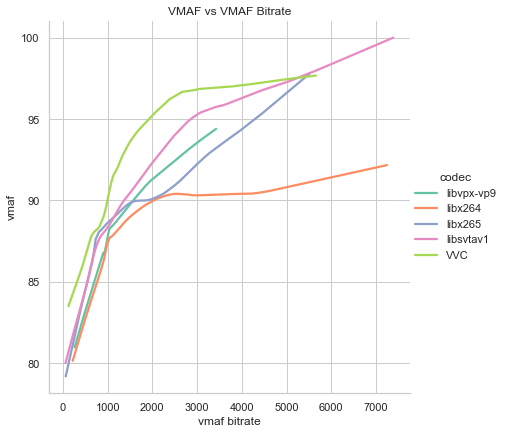

In [62]:
sns.lmplot(data=VideoDataInstance.powers_df, x="vmaf bitrate", y="vmaf", hue="codec", lowess=True, scatter=False, height=6, palette="Set2")
ax = plt.gca()
ax.set_title("VMAF vs VMAF Bitrate")
plt.savefig("VMAF_vs_Bitrate_lowess.pdf")

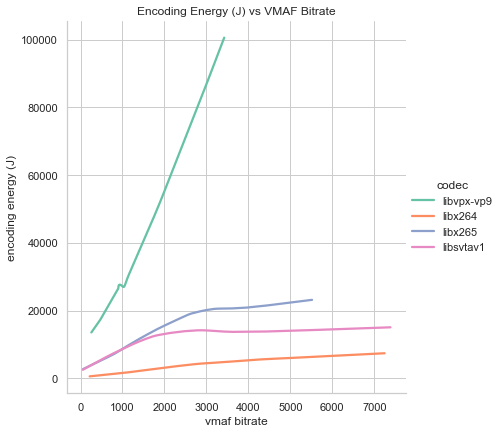

In [67]:
sns.lmplot(data=VideoDataInstance.powers_df[VideoDataInstance.powers_df.codec != "VVC"], y="encoding energy (J)", x="vmaf bitrate", hue="codec", scatter=False, lowess=True, ci=None, height=6, palette="Set2", legend=True)
ax = plt.gca()
ax.set_title("Encoding Energy (J) vs VMAF Bitrate")
plt.savefig("encoding_energy_vs_Bitrate_lowess.pdf")

Text(0.5, 1.0, 'VMAF vs Encoding Energy (J)')

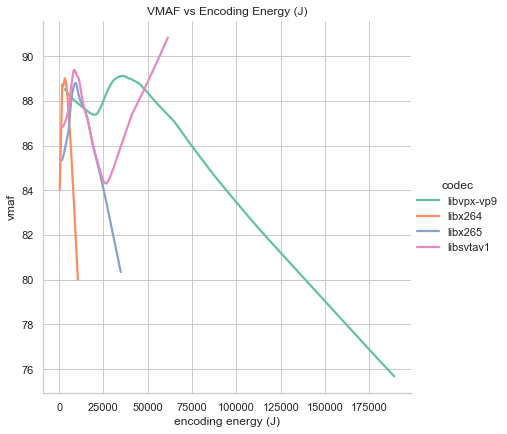

In [68]:
sns.lmplot(data=VideoDataInstance.powers_df[VideoDataInstance.powers_df.codec != "VVC"], x="encoding energy (J)", y="vmaf", hue="codec", scatter=False, lowess=True, ci=None, height=6, palette="Set2", legend=True)
ax = plt.gca()
ax.set_title("VMAF vs Encoding Energy (J)")

<AxesSubplot:xlabel='vmaf bitrate', ylabel='encoding energy (J)'>

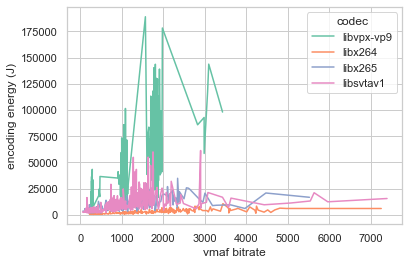

In [106]:
sns.lineplot(x="vmaf bitrate", y="encoding energy (J)", hue="codec", data=test_df, palette="Set2", ci=None)

<AxesSubplot:xlabel='encoding energy (J)', ylabel='vmaf'>

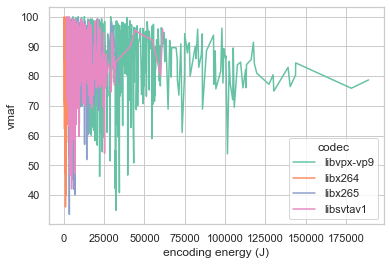

In [111]:
sns.lineplot(x="encoding energy (J)", y="vmaf", hue="codec", data=test_df, palette="Set2", ci=None)

In [12]:
test_df = pd.DataFrame.from_dict(VideoDataInstance.videos_flat, orient="index")
test_df.to_excel("full_data.xlsx")

In [65]:
test_dict = {}

for vid in VideoDataInstance.videos_flat.values():
    if "vmaf_target" not in vid:
        test_dict[f"{vid['video_name']}-{vid['resolution']}-{vid['codec']}"] = {"resolution": vid["resolution"], 
                                                             "target_encode_bitrate": vid["target_encode"]["bitrate"],  
                                                             "target_encode_qp": vid["target_encode"]["qp"], 
                                                             "target_encode_vmaf": vid["target_encode"]["vmaf"],
                                                             "vmaf_target_bitrate": None,  
                                                             "vmaf_target_qp": None, 
                                                             "vmaf_target_vmaf": None,
                                                             "evaluated_qp_energy": vid["evaluated_qp_energy"], 
                                                             "target_encode_energy": vid["target_encode"]["energy"],  
                                                             "codec": vid["codec"]}        
    else:
        test_dict[f"{vid['video_name']}-{vid['resolution']}-{vid['codec']}"] = {"resolution": vid["resolution"], 
                                                             "target_encode_bitrate": vid["target_encode"]["bitrate"],  
                                                             "target_encode_qp": vid["target_encode"]["qp"], 
                                                             "target_encode_vmaf": vid["target_encode"]["vmaf"],
                                                             "vmaf_target_bitrate": vid["vmaf_target"]["bitrate"],  
                                                             "vmaf_target_qp": vid["vmaf_target"]["qp"], 
                                                             "vmaf_target_vmaf": vid["vmaf_target"]["vmaf"],
                                                             "evaluated_qp_energy": vid["evaluated_qp_energy"], 
                                                             "target_encode_energy": vid["target_encode"]["energy"],  
                                                             "codec": vid["codec"]}

test_dict_df = pd.DataFrame.from_dict(test_dict, orient="index")
test_dict_df.to_excel("formatted_data.xlsx")
# test_dict_df

KeyError: 'evaluated_qp_energy'

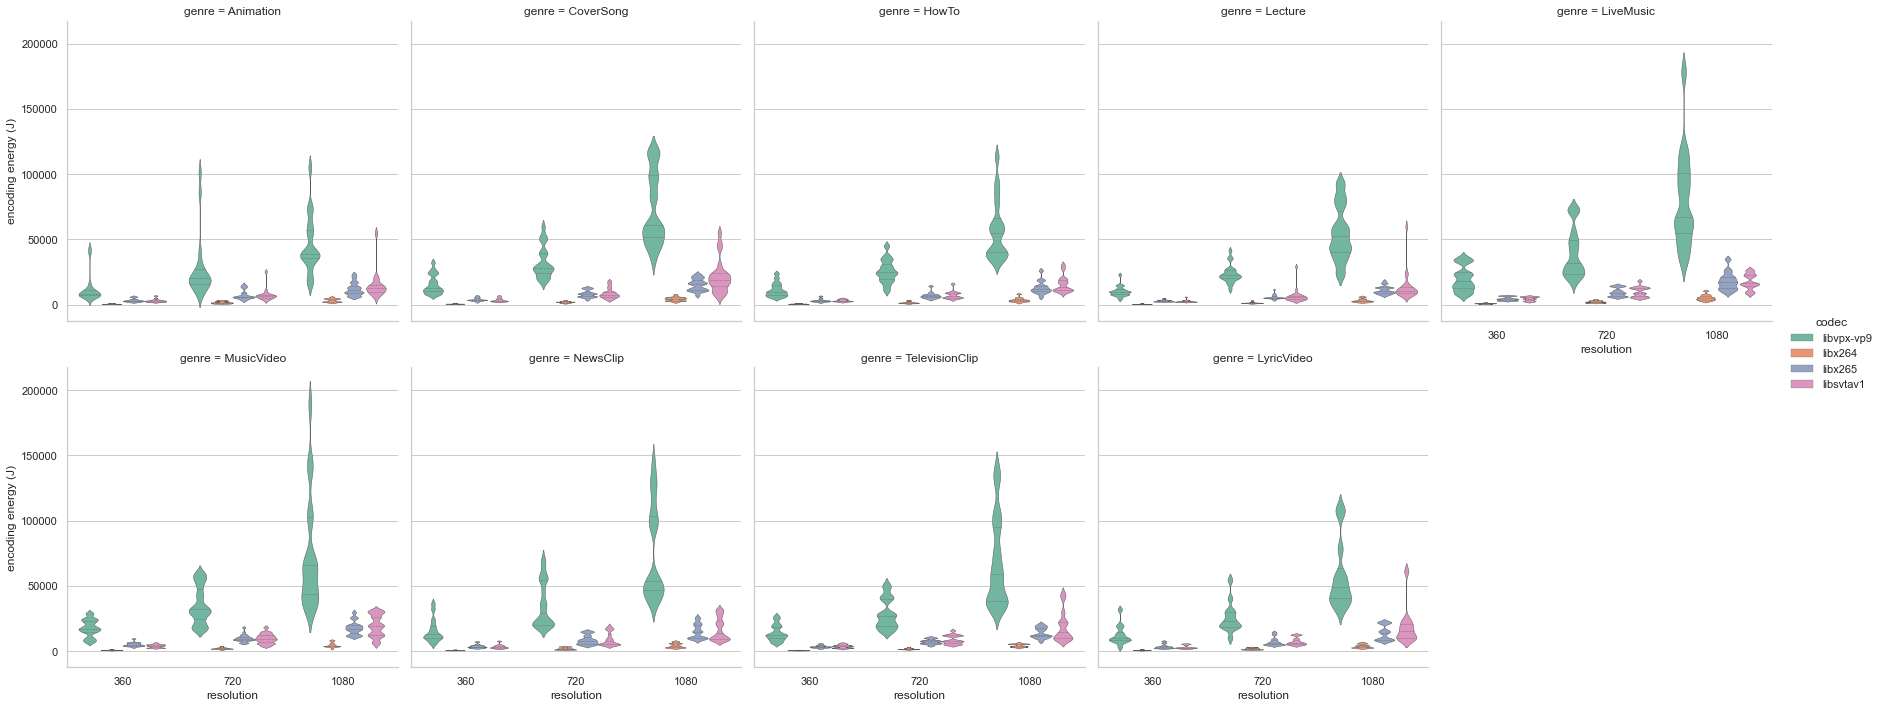

In [44]:
VideoDataInstance.get_violin_graphs()


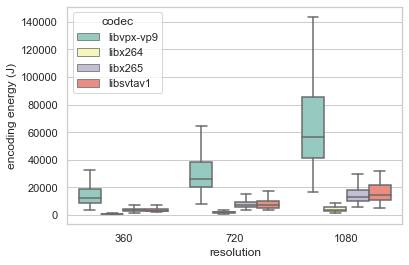

In [45]:
VideoDataInstance.get_res_energy_graph()

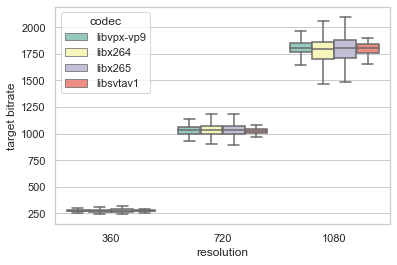

In [46]:
VideoDataInstance.get_res_bitrate_graph()

In [126]:
VideoDataInstance.vmaf_data.keys()

dict_keys(['libvpx-vp9', 'libx264', 'libx265', 'libsvtav1', 'VVC'])

In [169]:
with open("power/db_vmaf_yuv_2022-06-09.json") as f:
    vmaf_data = json.load(f)


errors = {}

for codec in vmaf_data.keys():

    for i, vid in enumerate(vmaf_data[codec].values()):
        if "error" in vid:
            errors.setdefault(codec, []).append(vid)
            # errors.setdefault(codec, []).append({"video_name": vid["video_name"], "resolution": vid["resolution"]})

In [170]:
with open("errors_full.json", "w") as f:
    json.dump(errors, f)

In [140]:
print(errors.keys())
print(len(errors["libvpx-vp9"]))
print(len(errors["libx264"]))
print(len(errors["libx265"]))
print(len(errors["libsvtav1"]))
print(len(errors["VVC"]))

dict_keys(['libvpx-vp9', 'libx264', 'libx265', 'libsvtav1', 'VVC'])
579
586
587
598
801


### Size Difference

In [15]:
rounded_mem = df_rounded.memory_usage(deep=True).sum()
unrounded_mem = df_unrounded.memory_usage(deep=True).sum()

print(f"Difference in memory usage: {(rounded_mem - unrounded_mem) / ((rounded_mem + unrounded_mem) / 2) * 100}")

rounded_file_size = 160007256
unrounded_file_size = 349845153

print(f"Difference in file size: {(rounded_file_size - unrounded_file_size) / ((rounded_file_size + unrounded_file_size) / 2) * 100}")

Difference in memory usage: -62.24425577626855
Difference in file size: -74.46778465648084


In [19]:
print(f"Unrounded file size is {unrounded_file_size/rounded_file_size}x larger")
print(f"Unrounded memory requirement is {unrounded_mem/rounded_mem}x more")

Unrounded file size is 2.186433051511114x larger
Unrounded memory requirement is 1.9036901673613928x more


In [9]:
for vid in vids_flat.values():
    video_times = get_video_time(vid)
    energies = get_energy_video(df_unrounded, video_times)
    
    evaluated_qp_energy = sum(energies[:-1])[0]
    target_encode_energy = energies[-1][0]
    
    for i, qp in enumerate(vid["evaluated_qps"]):
        qp["energy"] = energies[i][0]
        
    vid["target_encode"]["energy"] = target_encode_energy
    
    vid["evaluated_qp_energy"] = evaluated_qp_energy
    
vids_flat

{'0-libvpx-vp9': {'video_name': 'Animation_1080P-05f8',
  'resolution': 360,
  'evaluated_qps': [{'output_video_file_path': '/home/csxds/video_temp/videos/Animation_05f8_640x360_libvpx-vp9_27.mp4',
    'bitrate': 1650.553,
    'start_time': '2022-05-02 15:40:31.537',
    'end_time': '2022-05-02 15:41:04.308',
    'qp': 27,
    'vmaf': 92.546579,
    'start_time_vmaf': '2022-05-02 15:41:05.883',
    'end_time_vmaf': '2022-05-02 15:41:48.925',
    'vvcdec_output_path': None,
    'resized': True,
    'energy': 3758.9199394736843},
   {'output_video_file_path': '/home/csxds/video_temp/videos/Animation_05f8_640x360_libvpx-vp9_33.mp4',
    'bitrate': 1058.271,
    'start_time': '2022-05-02 15:41:49.071',
    'end_time': '2022-05-02 15:42:17.777',
    'qp': 33,
    'vmaf': 90.232278,
    'start_time_vmaf': '2022-05-02 15:42:19.354',
    'end_time_vmaf': '2022-05-02 15:43:02.277',
    'vvcdec_output_path': None,
    'resized': True,
    'energy': 3306.9503373333337},
   {'output_video_file_pat

In [74]:
test_dict = {}

for vid in vids_flat.values():
    test_dict[f"{vid['video_name']}-{vid['resolution']}"] = {"resolution": vid["resolution"], "bitrate": vid["target_encode"]["bitrate"],  "qp": vid["target_encode"]["qp"], "energy": vid["target_encode"]["energy"],  "codec": vid["codec"]}

In [75]:
print(len(vids_flat))
test_dict_df

1913


resolution   bitrate  qp       energy      codec
Animation_1080P-05f8         1080  1791.939  48  2369.699296  libsvtav1
CoverSong_1080P-0188          360   270.395  36   519.488937    libx265
HowTo_1080P-0267             1080  1814.750  45  2020.756737  libsvtav1
Lecture_1080P-011f           1080  1750.173  49  9048.200353  libsvtav1
LiveMusic_1080P-14af         1080  1842.413  45  2421.808533  libsvtav1
...                           ...       ...  ..          ...        ...
CoverSong_1080P-6f26         1080  1834.171  58  2344.346559  libsvtav1
MusicVideo_1080P-7265        1080  1848.264  32  1486.411454  libsvtav1
Lecture_1080P-6089           1080  1690.583  45  2270.811318  libsvtav1
MusicVideo_1080P-7706        1080  1821.570  37  5856.010337  libsvtav1
MusicVideo_1080P-7f2e        1080  1720.477  47  1698.283878  libsvtav1

[162 rows x 5 columns]

In [76]:
test_dict_df = pd.DataFrame.from_dict(test_dict, orient="index")

display(test_dict_df[test_dict_df["resolution"] == 360].groupby(["codec"]).mean())
display(test_dict_df[test_dict_df["resolution"] == 720].groupby(["codec"]).mean())
display(test_dict_df[test_dict_df["resolution"] == 1080].groupby(["codec"]).mean())

resolution     bitrate         qp       energy
codec                                                     
libsvtav1        360.0  284.008245  41.455782   544.363159
libvpx-vp9       360.0  284.731000   2.000000  1289.284118
libx265          360.0  269.587889  38.666667   699.331893

resolution      bitrate         qp       energy
codec                                                      
libsvtav1        720.0  1056.927748  39.516129  1322.392551
libvpx-vp9       720.0   982.589000  25.000000  4245.145549
libx265          720.0   973.465667  27.000000  1205.439123

resolution      bitrate        qp         energy
codec                                                       
VVC             1080.0  1922.898913  27.68000  107013.858792
libsvtav1       1080.0  1876.296946  39.27027    2775.303332
libvpx-vp9      1080.0  1844.610000   0.00000    3097.429653
libx265         1080.0  1482.256000  40.00000    2031.765882

### Tests

In [121]:
vid_times = get_video_time(vids_flat["0-libvpx-vp9"])

def test_get_video_times():
    vid_times = get_video_time(vids_flat["0-libvpx-vp9"])
    assert vid_times == [['2022-05-02 15:40:31.537', '2022-05-02 15:41:04.308'], ['2022-05-02 15:41:49.071', '2022-05-02 15:42:17.777'], ['2022-05-02 15:43:02.430', '2022-05-02 15:43:25.563'], ['2022-05-02 15:44:11.118', '2022-05-02 15:44:30.494'], ['2022-05-02 15:45:15.068', '2022-05-02 15:45:31.851'], ['2022-05-02 15:46:15.988', '2022-05-02 15:46:34.355']]
    
def test_get_energy_video():
    vid_energy = get_energy_video(df_unrounded, vid_times)
    evaluated_qp_energy = sum(vid_energy[:-1])[0]
    target_encode_energy = vid_energy[-1][0]
    
    assert evaluated_qp_energy == qp_energy[0]
    assert target_encode_energy == energy_target[0]

def run_tests():
    test_get_video_times()
    test_get_energy_video()
    print("Passed")
    
run_tests()

Passed


# Filling Gaps

In [46]:
def fill_gaps(df):
    deltas = df.index.to_series().diff()
    df.insert(1, "delta", deltas.dt.seconds)
    
    newdf = df.query('delta == 2')
    
    missing_times = newdf.index.to_frame().apply(lambda x: x - timedelta(0, 1))
    missing_times = missing_times.assign(power = lambda x: (df.loc[x.index]['power'] + df.loc[x.index - timedelta(0, 2)]['power'].values) / 2)
    missing_times.set_index('datetime', inplace=True)
    
    res = df.append(missing_times, ignore_index=False)
    res.sort_index(inplace=True)
    res = res.drop(columns=["delta"])
    df = df.drop(columns=["delta"])
    
    return res

In [34]:
df = df_rounded
deltas = df.index.to_series().diff()
df.insert(1, "delta", deltas.dt.seconds)

In [300]:
newdf = df.query('delta == 2')

In [305]:
missing_times = newdf.index.to_frame().apply(lambda x: x - timedelta(0, 1))

missing_times = missing_times.assign(power = lambda x: (df.loc[x.index]['power'] + df.loc[x.index - timedelta(0, 2)]['power'].values) / 2)
missing_times.set_index('datetime', inplace=True)
missing_times

power
datetime                       
2022-02-14 15:06:19  115.312500
2022-02-14 15:09:14  114.421875
2022-02-14 15:16:12  115.296875
2022-02-14 15:20:09  211.250000
2022-02-14 15:24:00  170.843750
...                         ...
2022-06-13 09:12:32   80.390625
2022-06-13 09:12:35   79.875000
2022-06-13 09:13:29   81.078125
2022-06-13 09:13:31   80.531250
2022-06-13 09:15:27   80.656250

[23956 rows x 1 columns]

In [307]:
res = df.append(test, ignore_index=False)
res.sort_index(inplace=True)
res = res.drop(columns=["delta"])
res

power
datetime                      
2022-02-14 15:05:56  115.87500
2022-02-14 15:05:57  116.18750
2022-02-14 15:05:58  115.53125
2022-02-14 15:05:59  114.37500
2022-02-14 15:06:00  114.09375
...                        ...
2022-06-13 09:19:18   80.93750
2022-06-13 09:19:19   79.68750
2022-06-13 09:19:20   80.06250
2022-06-13 09:19:21   81.03125
2022-06-13 09:19:22   81.93750

[5924122 rows x 1 columns]

In [308]:
res.iloc[[22,23,24,25,192,193]]

power
datetime                       
2022-02-14 15:06:18  114.437500
2022-02-14 15:06:19  115.312500
2022-02-14 15:06:20  116.187500
2022-02-14 15:06:21  115.125000
2022-02-14 15:09:12  115.020833
2022-02-14 15:09:13  113.906250

In [309]:
df.iloc[[22,23,24,25,192,193]]

power  delta
datetime                             
2022-02-14 15:06:18  114.43750    1.0
2022-02-14 15:06:20  116.18750    2.0
2022-02-14 15:06:21  115.12500    1.0
2022-02-14 15:06:22  114.03125    1.0
2022-02-14 15:09:13  113.90625    1.0
2022-02-14 15:09:15  114.93750    2.0

In [311]:
deltas = res.index.to_series().diff()
res.insert(1, "delta", deltas.dt.seconds)

ValueError: cannot insert delta, already exists

In [315]:
test = res.query('delta == 2')
test

Empty DataFrame
Columns: [power, delta]
Index: []

In [35]:
gaps = deltas[deltas > timedelta(0, 1)]
gaps

23        0 days 00:00:02
72        0 days 00:00:05
193       0 days 00:00:02
238       0 days 00:00:33
578       0 days 00:00:02
                ...      
5899760   0 days 00:00:02
5899762   0 days 00:00:02
5899815   0 days 00:00:02
5899816   0 days 00:00:02
5899931   0 days 00:00:02
Name: datetime, Length: 24156, dtype: timedelta64[ns]

In [36]:
sorted_gaps = gaps.sort_values(ascending=False)

In [37]:
sorted_gaps

1686122   44 days 13:31:00
2890453    2 days 18:06:15
1686147    1 days 08:25:01
427950     1 days 01:07:40
2293730    0 days 05:44:16
                ...       
1921153    0 days 00:00:02
1920750    0 days 00:00:02
1920578    0 days 00:00:02
1920406    0 days 00:00:02
5899931    0 days 00:00:02
Name: datetime, Length: 24156, dtype: timedelta64[ns]

In [ ]:
23750

In [42]:
deltas2 = df2['datetime'].diff()
gaps2 = deltas2[deltas2 > timedelta(0, 1)]
sorted_gaps2 = gaps2.sort_values(ascending=False)

In [43]:
sorted_gaps2

9558891    44 days 13:31:00
15704415    2 days 18:06:15
9559044     1 days 08:25:01
2436390     1 days 01:07:40
13003467    0 days 05:44:16
                 ...       
10889478    0 days 00:00:02
10887021    0 days 00:00:02
10885968    0 days 00:00:02
10884915    0 days 00:00:02
29123823    0 days 00:00:02
Name: datetime, Length: 24156, dtype: timedelta64[ns]

In [47]:
sorted_gaps2[sorted_gaps2 < timedelta(0, 3)]

20048956   0 days 00:00:02
20048492   0 days 00:00:02
20093890   0 days 00:00:02
20103058   0 days 00:00:02
20134818   0 days 00:00:02
                 ...      
10889478   0 days 00:00:02
10887021   0 days 00:00:02
10885968   0 days 00:00:02
10884915   0 days 00:00:02
29123823   0 days 00:00:02
Name: datetime, Length: 23956, dtype: timedelta64[ns]

# Fixing 10 watt difference

In [125]:
# df = pd.read_csv('power/power_log_2022-05-26.csv', names=['datetime', 'power'], dtype={'datetime': "string", "power": float}, usecols=(0, 1), low_memory=False)
df = pd.read_csv('test10.csv', dtype={'datetime': "string", "power": float}, usecols=(0, 1), low_memory=False)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [126]:
df

power
datetime                   
2022-02-14 15:05:56  116.06
2022-02-14 15:05:57  116.00
2022-02-14 15:05:58  114.94
2022-02-14 15:05:59  114.10
2022-02-14 15:06:00  114.25
...                     ...
2022-06-13 09:19:18   79.70
2022-06-13 09:19:19   80.30
2022-06-13 09:19:20   80.50
2022-06-13 09:19:21   81.80
2022-06-13 09:19:22   81.06

[5900552 rows x 1 columns]

<AxesSubplot:xlabel='datetime'>

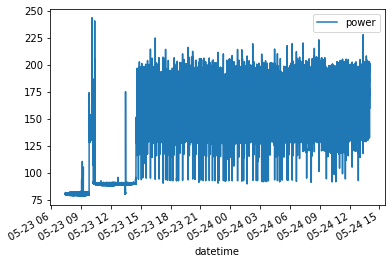

In [127]:
df['23-05-2022 07:25':'24-05-2022 14:00'].plot()

<AxesSubplot:xlabel='datetime'>

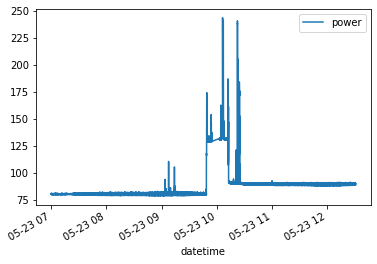

In [69]:
df['23-05-2022 07:00':'23-05-2022 12:30'].plot()

In [71]:
lower_power = df["23-05-2022 7:00" : "23-05-2022 9:00"]
higher_power = df["23-05-2022 10:30" : "23-05-2022 12:30"]

In [88]:
print(f"Lower avg: {lower_power.mean().values[0]}, higher avg: {higher_power.mean().values[0]}, diff: {higher_power.mean().values[0] - lower_power.mean().values[0]}")

Lower avg: 80.45737104135029, higher avg: 89.62018398118708, diff: 9.162812939836797


In [219]:
df.loc["23-05-2022 09:48"]

power
datetime                       
2022-05-23 09:48:00   79.900000
2022-05-23 09:48:01   79.800000
2022-05-23 09:48:02   80.500000
2022-05-23 09:48:03   81.300000
2022-05-23 09:48:04   81.100000
2022-05-23 09:48:05   80.750000
2022-05-23 09:48:06   79.750000
2022-05-23 09:48:07   80.250000
2022-05-23 09:48:08   81.000000
2022-05-23 09:48:09   81.250000
2022-05-23 09:48:10   80.800000
2022-05-23 09:48:11   80.400000
2022-05-23 09:48:12   79.600000
2022-05-23 09:48:13   80.400000
2022-05-23 09:48:14   81.060000
2022-05-23 09:48:15   81.400000
2022-05-23 09:48:16   80.900000
2022-05-23 09:48:17   79.900000
2022-05-23 09:48:18   79.750000
2022-05-23 09:48:19   80.500000
2022-05-23 09:48:20   80.900000
2022-05-23 09:48:21   81.250000
2022-05-23 09:48:22   80.600000
2022-05-23 09:48:23   79.750000
2022-05-23 09:48:24   80.000000
2022-05-23 09:48:25   80.400000
2022-05-23 09:48:26   81.400000
2022-05-23 09:48:27   81.000000
2022-05-23 09:48:28   80.440000
2022-05-23 09:48:29   79.700000
2022-05-23 09:48:30   80.100000
2022-05-23 09:48:31   80.900000
2022-05-23 09:48:32   81.750000
2022-05-23 09:48:33   81.250000
2022-05-23 09:48:34   80.200000
2022-05-23 09:48:35   79.800000
2022-05-23 09:48:36   80.560000
2022-05-23 09:48:37   81.250000
2022-05-23 09:48:38   85.500000
2022-05-23 09:48:39   80.750000
2022-05-23 09:48:40   79.750000
2022-05-23 09:48:41   79.750000
2022-05-23 09:48:42   80.750000
2022-05-23 09:48:43   81.100000
2022-05-23 09:48:44   81.700000
2022-05-23 09:48:45   80.250000
2022-05-23 09:48:46   79.750000
2022-05-23 09:48:47   83.500000
2022-05-23 09:48:48   81.437187
2022-05-23 09:48:49  103.937187
2022-05-23 09:48:50  106.237187
2022-05-23 09:48:51   88.437187
2022-05-23 09:48:52   84.737187
2022-05-23 09:48:53  100.837187
2022-05-23 09:48:54  105.087187
2022-05-23 09:48:55  106.837187
2022-05-23 09:48:56  106.587187
2022-05-23 09:48:57  105.737187
2022-05-23 09:48:58  105.637187
2022-05-23 09:48:59  106.587187

<AxesSubplot:xlabel='datetime'>

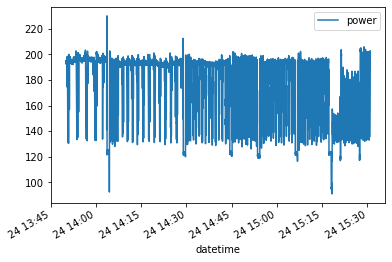

In [62]:
df['24-05-2022 13:50':'24-05-2022 15:30'].plot()

In [58]:
df.loc["24-05-2022 13:59"]

power
datetime                  
2022-05-24 13:59:00  195.9
2022-05-24 13:59:01  192.8
2022-05-24 13:59:02  189.1
2022-05-24 13:59:03  193.5
2022-05-24 13:59:04  184.0
2022-05-24 13:59:05  195.8
2022-05-24 13:59:06  194.6
2022-05-24 13:59:07  195.5
2022-05-24 13:59:08  197.0
2022-05-24 13:59:09  197.2
2022-05-24 13:59:10  196.0
2022-05-24 13:59:11  195.1
2022-05-24 13:59:12  193.9
2022-05-24 13:59:13  193.8
2022-05-24 13:59:14  195.2
2022-05-24 13:59:15  196.2
2022-05-24 13:59:16  197.2
2022-05-24 13:59:17  195.5
2022-05-24 13:59:18  196.8
2022-05-24 13:59:19  197.8
2022-05-24 13:59:20  196.8
2022-05-24 13:59:21  184.0
2022-05-24 13:59:22  181.0
2022-05-24 13:59:23  172.1
2022-05-24 13:59:24  171.2
2022-05-24 13:59:25  181.0
2022-05-24 13:59:26  190.5
2022-05-24 13:59:27  190.8
2022-05-24 13:59:28  186.2
2022-05-24 13:59:29  182.2
2022-05-24 13:59:30  179.2
2022-05-24 13:59:31  178.0
2022-05-24 13:59:32  163.5
2022-05-24 13:59:33  163.8
2022-05-24 13:59:34  163.0
2022-05-24 13:59:35  155.2
2022-05-24 13:59:36  157.5
2022-05-24 13:59:37  158.6
2022-05-24 13:59:38  153.4
2022-05-24 13:59:39  154.6
2022-05-24 13:59:40  143.0
2022-05-24 13:59:41  138.0
2022-05-24 13:59:42  132.8
2022-05-24 13:59:43  135.8
2022-05-24 13:59:44  145.5
2022-05-24 13:59:45  154.0
2022-05-24 13:59:46  163.1
2022-05-24 13:59:47  173.9
2022-05-24 13:59:48  182.6
2022-05-24 13:59:49  194.8
2022-05-24 13:59:50  188.5
2022-05-24 13:59:51  182.0
2022-05-24 13:59:52  176.2
2022-05-24 13:59:53  168.5
2022-05-24 13:59:54  168.4
2022-05-24 13:59:55  155.8
2022-05-24 13:59:56  149.8
2022-05-24 13:59:57  141.0
2022-05-24 13:59:58  132.6
2022-05-24 13:59:59  136.0